### Corrective RAG

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [18]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter 

urls = [
    "https://docs.langchain.com/oss/python/releases/langgraph-v1",
    "https://docs.langchain.com/oss/python/langgraph/use-subgraphs",
    "https://docs.langchain.com/oss/python/langgraph/add-memory"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = FAISS.from_documents(
    documents = doc_splits,
    embedding = OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()



In [19]:
retriever.invoke("What is langgraph?")

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/releases/langgraph-v1', 'title': "What's new in LangGraph v1 - Docs by LangChain", 'language': 'en'}, page_content='Itâ€™s designed to work hand-in-hand with LangChain v1 (whose create_agent is built on LangGraph) so you can start high-level and drop down to granular control when needed.'),
 Document(metadata={'source': 'https://docs.langchain.com/oss/python/releases/langgraph-v1', 'title': "What's new in LangGraph v1 - Docs by LangChain", 'language': 'en'}, page_content="What's new in LangGraph v1 - Docs by LangChainSkip to main contentðŸš€ Share how you're building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...âŒ˜KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangGraph v1.0What's new in LangGraph v1LangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewLangGraph v1.0Release notesMigration guideGet startedInstallQuickstartLocal se

In [20]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [22]:
tools = [retriever_tool]

### Graph Creation

In [79]:
from typing import Annotated,Sequence
from typing_extensions import TypedDict,Literal
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field

class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],add_messages]

In [86]:
from langchain_openai import ChatOpenAI

def agent(state:AgentState):
    """ 
    Invokes the agent model to generate a response based on the current state. Given
    the question, It will decide to retrieve using the retriever tool, or simply end.

    Args:
        state(messages) : The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    
    """
    messages = state["messages"]
    print("---- Before Agent STATE STATUS----")
    print(state)
    model = ChatOpenAI(model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    return {"messages":[response]}


In [98]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

def generate(state: AgentState):
    """ 
    Generate Answer

    Args:
        state (messages): The current state

    Returns
        dict: The updated message
    """
    print("--GENERATE--")
    messages = state["messages"]
    print("---- Before generate STATE STATUS----")
    print(state)
    
    question = messages[0].content
    docs = messages[-1].content

    prompt = hub.pull("rlm/rag-prompt")

    llm = ChatOpenAI(model="gpt-4-turbo")

    def format_docs(docs):
        return "\n\n".join([doc for doc in docs])

    docs = format_docs(docs)

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context":docs,"question":question})

    return {"messages":[response]}


In [93]:
def rewrite(state:AgentState):
    """ 
        Transform the query to produce a better question

        Args:
        state (messages): the current state

        returns
        dict: The updated state with re-phrased question
    """
    print("--- TRANSFORM QUERY---")

    messages = state["messages"]
    print("---- Before Re-write STATE STATUS----")
    print(state)
    question = messages[0].content

    msg = [
            HumanMessage(
                content=f""" \n 
        Look at the input and try to reason about the underlying semantic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
            )
        ]
    
    model = ChatOpenAI(model="gpt-4-turbo")
    response = model.invoke(msg)
    print([response])
    return {"messages":[response]}

In [94]:
def grade_documents(state:AgentState)->Literal["rewrite","generate"]:
    """ 
    Determines whether the retrieved documents relevant to the question.

    Args:
      state (messages): The current state

    Returns:
      str: A decision for whether the documents are relevant or not.
    """
    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        """Binary score for relevance check"""
        binary_score:str = Field(description="Relevance score 'yes' or 'No'")

    llm = ChatOpenAI(model="gpt-4-turbo")

    llm_with_tool = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    messages = state['messages']
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question":question,"context":docs})
    score = scored_result["binary_score"]

    if score == "yes":
        print("---DECISION: DOCS RELEVANT")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT")
        print(score)
        return "rewrite"

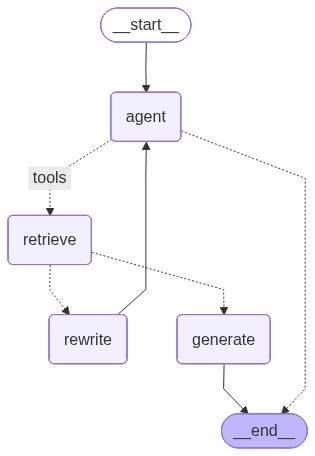

In [95]:
from langgraph.graph import END,StateGraph,START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image
workflow = StateGraph(AgentState)

workflow.add_node("agent",agent)
workflow.add_node("retrieve",ToolNode([retriever_tool]))
workflow.add_node("rewrite",rewrite)
workflow.add_node("generate",generate)

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",
                                tools_condition,
                                {
                                    "tools":"retrieve",
                                    END: END
                                }
                                )
workflow.add_conditional_edges(
    "retrieve",
    grade_documents
)
workflow.add_edge("rewrite","agent")
workflow.add_edge("generate",END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
graph.invoke({"messages": "what is Langchain?"})

---- Before Agent STATE STATUS----
{'messages': [HumanMessage(content='what is Langchain?', id='1a85d6e9-ef14-44d2-a241-37b4d4e5afc3')]}
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT
--GENERATE--
---- Before generate STATE STATUS----
{'messages': [HumanMessage(content='what is Langchain?', id='1a85d6e9-ef14-44d2-a241-37b4d4e5afc3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DM3Zslbitx8bexKhXqOWT5Fd', 'function': {'arguments': '{"query":"Langchain"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 64, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b1c0a130-ef

c:\Users\DELL\anaconda3\envs\llmapp\Lib\site-packages\langchain\hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


{'messages': [HumanMessage(content='what is Langchain?', id='1a85d6e9-ef14-44d2-a241-37b4d4e5afc3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DM3Zslbitx8bexKhXqOWT5Fd', 'function': {'arguments': '{"query":"Langchain"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 64, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b1c0a130-efd2-44e0-b258-d98f4c9219f4-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Langchain'}, 'id': 'call_DM3Zslbitx8bexKhXqOWT5Fd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 19, 'tota